In [1]:
# Solutions to homework 2 for Astr 511, see
# http://www.astro.washington.edu/users/ivezic/t_astr511.html
# this is how SM code translated to python looks and feels... 
# Author: Zeljko Ivezic <ivezic@uw.edu>
import os
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.optimize import curve_fit
from astroML.stats import median_sigmaG
from astroML.plotting import scatter_contour
from astroML.lumfunc import bootstrap_Cminus
from astroML.cosmology import Cosmology

In [2]:
# Astr511 howework 2 includes: 
# 
# a) Define a ``gold parallax sample" by piObs/piErr > 10. Compute the distance 
#     and distance modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) 
#     and compare it to the distance modulus determined from r and Mr listed in the 
#     ``truth" file: 
#     - plot the distribution of the distance modulus difference and compute its median
#       and root-mean-square scatter (hint: beware of outliers and clip at 3sigma!). Are 
#       they ``interestingly" small? Is the distribution deviating from a gaussian? Would 
#       you expect it to? Why? How many white dwarfs would you expect in a ``gold parallax 
#       sample" from the full LSST survey area of 20,000 deg2 (hint: simply scale by the 
#       area because the distance cutoff is smaller than the thin disk scaleheight)? 
#     - plot the (g-r) vs. (u-g) color-color diagram (using observed photometry) for 
#       this sample. Does it look crisper than the SDSS distribution shown in the bottom 
#       left corner of fig. 23 in Ivezic et al. (2007, AJ, 134, 973)? Hint: look at the 
#       two bottom panels in fig. 24.
#
# b) Using the ``gold parallax sample" from a), estimate the absolute r band magnitude as 
#     Mobs = rObs - DMobs, with the observed distance modulus, DMobs, determined using the 
#     ``measured" trigonometric parallax, piObs. 
#     - plot Mobs vs. (gObs-rObs) color for stars with T=1 (i.e., hydrogen white WDs; while
#       this is a shortcut based on model input, it is possible to photometrically distinguish
#       hydrogen from helium WDs by considering their four-dimensional color loci; however, 
#       this is beyond the scope of this project and hence this shortcut). Fit a low-order 
#       polynomial to derive a photometric parallax relation, Mr(g-r) (hint: you may want 
#       to first compute the median Mr in about 0.1 mag wide bins of the g-r color, and then 
#       fit a polynomial to these median values vs. g-r bin value). How did you choose the 
#       order of your polynomial fit? In what range of Mr and (g-r) is your relation valid?
#
# c) Define a ``gold proper motion sample" by requiring rObs<24.5. What fraction of this 
#     sample has the observed proper motion measured with a signal-to-noise ratio (to
#     compute SNR: add the two proper motion components in quadrature and divide by the
#     listed proper motion error) of at least 3? Apply your photometric parallax relation 
#     from b) to estimate Mr and distance (using Mr and rObs). Use this distance to compute
#     tangential velocity, vtan (of course, you also need the observed proper motion; be
#     careful about units!). Define a candidate disk sample as stars with vtan < vcutoff, and
#     a candidate halo sample as stars with vtan > vcutoff. Using P from the truth file, 
#     - plot the completeness and contamination for disk and halo samples as a function of 
#       vcutoff for 0 < vcutoff < 500 km/s (in steps of, say, 20 km/s). The completeness is 
#       defined as the number of (disk, halo) objects in the selected subsample divided by the 
#       total number of such objects, and contamination is the number of objects of the 
#       ``wrong" type in the selected subsample divided by the total number in that subsample.
#
# d) Using the ``gold proper motion sample" from c), define a candidate disk sample by 
#    vtan < 150 km/s, and a candidate halo sample by vtan > 200 km/s. Using your results from 
#    c), estimate the completeness and contamination for each subsample. Using the C- method, 
#    compute the differential luminosity function for each subsample (this is the hardest part 
#    of this project!). Explain how did you get the normalization constant. 
#    - plot your results in a log(Phi) vs. Mr diagram (with error bars!), and overplot the true 
#      luminosity function listed in files WDlumfuncHalo.dat and WDlumfuncHalo.dat (the 
#      differential LF listed in the second column is expressed as the number of stars per pc^3 
#      and mag; the LFs are slightly inconsistent with the Harris et al. due to a bug in 
#      simulations but, importantly, they do correspond to the ``true" LFs for the simulated 
#      sample). Comment on (dis)agreement between your Phi and the true Phi (which was used to 
#      generate the simulated sample).
#
# e) A ``byproduct" of the luminosity function determination in D is the spatial distribution 
#     of stars. Plot the results for disk and halo subsamples (i.e., ln(rho) vs. Z, with error 
#     bars!). Compare these profiles to the spatial profiles you determined as a part of 
#     project #1 and comment.

In [3]:

def getWDdata():
    """Get the simulated white dwarf data"""
    # read truth data file, with the following columns:
    # <ra dec u g r i z y Mr logg vR vPhi vZ T P>
    dataT = np.loadtxt('LSSTsimWDtruth60.dat')
    truth = dataT.transpose(1,0)
    # read observations data file, with the following columns:
    # <ra dec uObs uErr gObs gErr rObs rErr iObs iErr zObs zErr yObs yErr
    #  piObs piErr muRAObs muDecObs muErr> 
    dataO = np.loadtxt('LSSTsimWDobs60.dat')
    obs = dataO.transpose(1,0)
    return truth, obs


def getLFdata():
    """Get luminosity functions used to simulate white dwarf samples"""
    trueLFdisk = np.loadtxt('WDlumfuncDisk.dat')
    tLFdisk = trueLFdisk.transpose(1,0)
    trueLFhalo = np.loadtxt('WDlumfuncHalo.dat')
    tLFhalo = trueLFhalo.transpose(1,0)
    return tLFdisk, tLFhalo


def IntDiffDistr(x, y, xLimit):
    ## return the integral of y(x) up to xmax (from the starting point)
    ## it is assumed that the length of x is by 1 larger than the length of y
    ## x represents bin boundaries for a piecewise constant y(x)
    # integrated function (the term in parenthesis is dx)
    intfunc = y * (x[1:] - x[:-1])
    xmax = x[1:]
    return np.sum(intfunc[xmax <= xLimit])


def ExpDiskDensity(distance, A, H): # ln(rho) = A - H*distance
    # helper function for fitting exp. disk
    return A - H*distance

def WDppFit(x, A, B, C, D, E): # 
    # helper function for fitting
    # also Mr(gr) evaluator for Hydrogen WDs (x=gr, returns Mr) 
    return A + B*x + C*x**2 + D*x**3 + E*x**4


def fitPhotomParallax(truth, obs):

    piObs = obs[14]
    piErr = obs[15]
    piSNR = piObs / piErr
    D = np.where(piObs>0, 1/piObs, 1.0e6) 
    # only using good parallax values (SNR>10)
    mask = (piSNR>10) 
    Dok = D[mask]
    DMok = 5*np.log10(Dok/0.01)
    rObs = obs[6]
    rObsOK = rObs[mask]
    MrObsOK = rObsOK - DMok
    gr = obs[4]-obs[6]
    grOK = gr[mask]
    # select only hydrogen white dwarfs 
    TypeWD = truth[13]
    TypeWDok = TypeWD[mask]
    xFit = grOK[(TypeWDok == 1)]
    yFit = MrObsOK[(TypeWDok == 1)]

    # OK, now fit yFit(xFit) with a 4-th order polynomial (set in WDppFit) 
    A, B, C, D, E = curve_fit(WDppFit, xFit, yFit)[0]
    MrFit = WDppFit(xFit, A, B, C, D, E)
    dMr = yFit - MrFit
    print('Mr fitting bias and rms:', np.median(dMr), np.sqrt(np.var(dMr)))

    return A, B, C, D, E

In [4]:
def doAstr511HW2(truth, obs, diskLF, haloLF, verbose=0):
    """Make a six-panel plot illustrating Astr511 homework #2"""

    # a) Define a ``gold parallax sample" by piObs/piErr > 10 and compare distance 
    #    modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) 
    #    to the distance modulus determined from r and Mr listed in the ``truth" file 
    piObs = obs[14]
    piErr = obs[15]
    piSNR = piObs / piErr
    D = np.where(piObs>0, 1/piObs, 1.0e6) 
    mask = (piSNR>10) 
    Dok = D[mask]
    DM = 5*np.log10(Dok/0.01)
    DMtrue = truth[4] - truth[8]
    diffDM = DM - DMtrue[mask]

    if (verbose):
        print('  mean =', np.mean(diffDM))
        print('   rms =', np.std(diffDM))
        med, sigG = median_sigmaG(diffDM)
        print('median =', med)
        print('sigmaG =', sigG)

    ### make vectors of x=distance modulus and y=absolute magnitude to run Cminus
    # sample faint limit
    rFaintLimit = 24.5
    # use either true distances, or estimated from parallax
    if (0):
        # using "truth" values of distance modulus, DM, to compute LF
        Mr = truth[8]
        rTrue = truth[4]
        DMtrue = rTrue - Mr 
        # type could be estimated from colors...
        typeWD = truth[13]
        # here the sample is defined using true apparent magnitude
        maskC = (rTrue < rFaintLimit) & (typeWD == 1) 
        xC = DMtrue[maskC]
        yC = Mr[maskC]
    else:
        # observed apparent magnitude
        rObs = obs[6]
        if (1):
            # fit a 4-th order polynomial to Mr(gr) relation (high-SNR sample)
            A, B, C, D, E = fitPhotomParallax(truth, obs)
            # and now apply
            gr = obs[4]-obs[6]
            MrPP = WDppFit(gr, A, B, C, D, E)
        else:
            # testing here: take true Mr...
            MrPP = truth[8]
        # here the sample is defined using observed apparent magnitude
        DMobs = rObs - MrPP
        # type could be estimated from colors...
        typeWD = truth[13]
        maskC = (rObs < rFaintLimit)  & (typeWD == 1) 
        xC = DMobs[maskC]
        yC = MrPP[maskC]


    ## the sample boundary is a simple linear function because using DM
    xCmax = rFaintLimit - yC
    yCmax = rFaintLimit - xC 
    ## split disk and halo, assume populations are known
    pop = truth[14]
    popC = pop[maskC]
    maskD = (popC==1) 
    xCD = xC[maskD]
    yCD = yC[maskD]
    xCmaxD = xCmax[maskD]
    yCmaxD = yCmax[maskD]
    maskH = (popC==2) 
    xCH = xC[maskH]
    yCH = yC[maskH]
    xCmaxH = xCmax[maskH]
    yCmaxH = yCmax[maskH]

    print('observed sample size of xCD (disk)', np.size(xCD))
    print('observed sample size of xCH (halo)', np.size(xCH))

    ### and now corrected Mr distributions: application of the Cminus method
    ## note that Cminus returns **cumulative** distribution functions
    ## however, bootstrap_Cminus (which calls Cminus) then does conversion 
    ## and returns **differential** distribution functions 

    #### this is where we run Cminus method (or use stored results) ####
    archive_file = 'CminusZI.npz'
    if not os.path.exists(archive_file):
        print("- computing bootstrapped differential luminosity function ")
        #------------------------------------------------------------
        # aux arrays 
        x_fit = np.linspace(0, 15, 42)
        y_fit = np.linspace(10, 17, 42)
        #------------------------------------------------------------
        ## compute the Cminus distributions (with bootstrap)
        # disk subsample 
        print ("Disk sample with %i points" % len(xCD))
        xD_dist, dxD_dist, yD_dist, dyD_dist = bootstrap_Cminus(xCD, yCD, xCmaxD, yCmaxD,
                                                    x_fit, y_fit, Nbootstraps=20, normalize=True)
        # halo subsample 
        print ("Halo sample with %i points" % len(xCH))
        xH_dist, dxH_dist, yH_dist, dyH_dist = bootstrap_Cminus(xCH, yCH, xCmaxH, yCmaxH,
                                                    x_fit, y_fit, Nbootstraps=20, normalize=True)
        np.savez(archive_file,
                 x_fit=x_fit, xD_dist=xD_dist, dxD_dist=dxD_dist,
                 y_fit=y_fit, yD_dist=yD_dist, dyD_dist=dyD_dist)
        archive_file = 'CminusZIhalo.npz'
        np.savez(archive_file,
                 xH_dist=xH_dist, dxH_dist=dxH_dist,
                 yH_dist=yH_dist, dyH_dist=dyH_dist)

        #------------------------------------------------------------
    else:
        print("- using ZI's precomputed bootstrapped luminosity function results")
        # disk
        archive_file = 'CminusZI.npz'
        archive = np.load(archive_file)
        x_fit = archive['x_fit']
        xD_dist = archive['xD_dist']
        dxD_dist = archive['dxD_dist']
        y_fit = archive['y_fit']
        yD_dist = archive['yD_dist']
        dyD_dist = archive['dyD_dist']
        # halo
        archive_file = 'CminusZIhalo.npz'
        archive = np.load(archive_file)
        xH_dist = archive['xH_dist']
        dxH_dist = archive['dxH_dist']
        yH_dist = archive['yH_dist']
        dyH_dist = archive['dyH_dist']
        
    # bin mid positions for plotting the results:
    x_mid = 0.5 * (x_fit[1:] + x_fit[:-1])
    y_mid = 0.5 * (y_fit[1:] + y_fit[:-1])


    ### determine normalization of luminosity functions and number density distributions
    ## we need to renormalize LFs: what we have are differential distributions
    ## normalized so that their cumulative LF is 1 at the last point;
    ## we need to account for the fractional sky coverage and for flux selection effect
    ## and do a bit of extrapolation to our position (DM=0) at the end
    # 1) the fraction of covered sky: we know that the sample is defined by bGal > bMin
    bMin = 60.0  # in degrees
    # in steradians, given b > 60deg, dOmega = 2*pi*[1-cos(90-60)] = 0.8418 sr
    dOmega = 2*math.radians(180)*(1-math.cos(math.radians(90-bMin)))

    # 2) renormalization constants due to selection effects
    # these correspond to the left-hand side of eq. 12 from lecture 4 (page 26)
    DMmax0 = 11.0
    MrMax0 = rFaintLimit - DMmax0
    NmaskD = ((xCD < DMmax0) & (yCD < MrMax0)) 
    Ndisk = np.sum(NmaskD)
    NmaskH = ((xCH < DMmax0) & (yCH < MrMax0)) 
    Nhalo = np.sum(NmaskH)
    print('Size of volume-limited samples D and H:', Ndisk, ' and ', Nhalo,  '(DM<', DMmax0, ', Mr<', MrMax0, ')')
       ## Size of volume-limited samples D and H: 49791  and  2065 (DM< 11.0 , Mr< 13.5 )

    # now we need to find what fraction of the total sample (without flux selection effects)
    # is found for x < DMmax0 and y < MrMax0. To do so, we need to integrate differential 
    # distributions returned by bootstrap_Cminus up to x=DMmax0 and y=MrMax0
    # (NB: we could have EASILY read off these from the original cumulative distributions returned
    #      from Cminus, but unfortunately bootstrap_Cminus returns only differential distributions;
    #      a design bug??) 
    # n.b. verified that all four distributions integrate to 1
    XfracD = IntDiffDistr(x_fit, xD_dist, DMmax0)
    YfracD = IntDiffDistr(y_fit, yD_dist, MrMax0)
    XfracH = IntDiffDistr(x_fit, xH_dist, DMmax0)
    YfracH = IntDiffDistr(y_fit, yH_dist, MrMax0)
    # and use eq. 12 to obtain normalization constant C for both subsamples
    Cdisk = Ndisk / (XfracD * YfracD)
    Chalo = Nhalo / (XfracH * YfracH)
    print('Cdisk = ', Cdisk, 'Chalo = ', Chalo)
       ## Cdisk = 608,082  Chalo = 565,598

    ## number density normalization
    # need to go from per DM to per pc:  dDM/dV = 5 / [ln(10) * dOmega * D^3] 
    Dpc = 10 * 10**(0.2*x_mid)
    # the units are "number of stars per pc^3" (of all absolute magnitudes Mr) 
    # note that here we assume isotropic sky distribution (division by dOmega!) 
    rhoD = Cdisk * 5/np.log(10)/dOmega / Dpc**3 * xD_dist
    rhoH = Chalo * 5/np.log(10)/dOmega / Dpc**3 * xH_dist
    # same fractional errors remain after renormalization 
    dxD_distN = rhoD * dxD_dist / xD_dist
    dxH_distN = rhoH * dxH_dist / xH_dist

    # differential luminosity function: per pc3 and mag, ** at the solar position **
    # to get proper normalization, we simply multiply differential distributions (whose
    # integrals are already normalized to unity by the local number density distributions)
    # Therefore, we need to extrapolate rhoD and rhoH to D=0
    # and then use these values as normalization factors
    # The choice of extrapolation function is tricky (much more so than in case of
    # interpolation): based on our "prior knowledge", we choose
    # for disk: fit exponential disk, ln(rho) = ln(rho0) - H*D for 100 < D/pc < 500
    # (note that H is short for 1/H, isn't that obvious?) 
    xFitExpDisk = Dpc[(Dpc > 100) & (Dpc < 500)]
    yFitExpDisk = np.log(rhoD[(Dpc > 100) & (Dpc < 500)])
    A, H = curve_fit(ExpDiskDensity, xFitExpDisk, yFitExpDisk)[0]
    rhoD0 = np.exp(A) 
    print('rhoD0', rhoD0, ' scale height H (pc) =', 1/H)
    # and for halo: simply take the median value for 500 < D/pc < 2000
    rhoH0 = np.median(rhoH[(Dpc > 500) & (Dpc < 2000)])
    print('rhoH0', rhoH0)
    # and now renormalize (rhoD0, rhoH0 = 0.0047 and 0.0000217) 
    # the units are "number of stars per pc^3 AND per mag" (at D=0)
    yD_distN = yD_dist * rhoD0
    yH_distN = yH_dist * rhoH0 
    # same fractional errors remain after renormalization 
    dyD_distN = yD_distN * dyD_dist / yD_dist
    dyH_distN = yH_distN * dyH_dist / yH_dist


    ### PLOTTING ###
    fig = plt.figure(figsize=(9, 9))
    # plot_kwargs = dict(color='k', linestyle='none', marker='.', markersize=1)
    fig.subplots_adjust(bottom=0.09, top=0.96, left=0.09, right=0.96, wspace=0.3, hspace=0.3)

    # plot the distribution of the distance modulus difference and compute its median
    # and root-mean-square scatter (hint: beware of outliers and clip at 3sigma!)
    hist, bins = np.histogram(diffDM, bins=50)    ## N.B. diffDM defined at the top
    center = (bins[:-1]+bins[1:])/2
    ax1 = fig.add_subplot(3,2,1)
    ax1.plot(center, hist, drawstyle='steps')   
    ax1.set_xlim(-1, 1)
    ax1.set_xlabel(r'$\mathrm{\Delta DM (mag)}$')
    ax1.set_ylabel(r'$\mathrm{dN/d(\Delta DM)}$')
    ax1.set_title('parallax SNR>10')
    ax1.plot(label=r'mpj legend')

    # overplot Gaussian
    dDMgrid = np.linspace(-0.8, 0.8, 100)
    mm = -0.035
    gg =  0.138
    histBinSize = bins[1]-bins[0]
    gauss = histBinSize * np.size(diffDM)/np.sqrt(2*3.14159)/gg * np.exp(-(dDMgrid-mm)**2/2/gg**2) 
    ax1.plot(dDMgrid, gauss, color='red')   

    # add legend 
    plt.text(0.25, 0.9,
         r'$\bar{x}=-0.023$',
         fontsize=12, bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.75, 0.9,
         r'$med.=-0.035$',
         fontsize=12, bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.2, 0.7,
         r'$\sigma=0.158$',
         fontsize=12, bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.75, 0.7,
         r'$\sigma_G=0.138$',
         fontsize=12, bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)


    # plot uncorrected Mr vs. DM for disk
    ax2 = fig.add_subplot(3,2,2)
    ax2.set_xlim(4, 15)
    ax2.set_ylim(17, 10)
    ax2.set_xlabel(r'$\mathrm{DM}$')
    ax2.set_ylabel(r'$\mathrm{M_{r}}$')
    scatter_contour(xCD, yCD, threshold=20, log_counts=True, ax=ax2,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker='.', linestyle='none',
                               markersize=1, color='black'),
                contour_args=dict(cmap=plt.cm.bone))
    # ax2.plot(xCmaxD, yCD, color='blue')
    plt.text(0.75, 0.20,
         r'$disk$',
         fontsize=22, bbox=dict(ec='k', fc='w', alpha=0.3),
         ha='center', va='center', transform=plt.gca().transAxes)


    # plot uncorrected Mr vs. DM for halo
    ax3 = fig.add_subplot(3,2,3)
    ax3.set_xlim(4, 15)
    ax3.set_ylim(17, 10)
    ax3.set_xlabel(r'$\mathrm{DM}$')
    ax3.set_ylabel(r'$\mathrm{M_{r}}$')
    scatter_contour(xCH, yCH, threshold=20, log_counts=True, ax=ax3,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker='.', linestyle='none',
                               markersize=1, color='black'),
                contour_args=dict(cmap=plt.cm.bone))
    # ax3.plot(xCH, yCmaxH, '.k', markersize=0.1, color='blue')
    plt.text(0.75, 0.20,
         r'$halo$',
         fontsize=22, bbox=dict(ec='k', fc='w', alpha=0.3),
         ha='center', va='center', transform=plt.gca().transAxes)


    # uncorrected Mr distributions 
    ax4 = fig.add_subplot(3,2,4)
    ax4.hist(yCD, bins=30, log=True, histtype='step', color='red')
    ax4.hist(yCH, bins=30, log=True, histtype='step', color='blue')
    ax4.set_xlim(10, 17)
    ax4.set_ylim(1, 50000)
    ax4.set_xlabel(r'$\mathrm{M_r}$')
    ax4.set_ylabel(r'$\mathrm{dN/dM_r}$')
    plt.text(0.52, 0.20,
         r'$uncorrected \,\,\, M_r \,\,\, distribution$',
         fontsize=12, bbox=dict(ec='k', fc='w', alpha=0.3),
         ha='center', va='center', transform=plt.gca().transAxes)

    ## now plot the two remaining panels: corrected rho and Mr distributions
    # density distributions
    ax5 = fig.add_subplot(325, yscale='log')
    ax5.errorbar(Dpc, rhoD, dxD_distN, fmt='-o', ecolor='red', lw=1, color='red', label='disk')
    ax5.errorbar(Dpc, rhoH, dxH_distN, fmt='-o', ecolor='blue', lw=1, color='blue', label='halo')

    ax5.set_xlim(0, 5000)
    ax5.set_ylim(0.000001, 0.01)
    ax5.set_xlabel(r'$\mathrm{D (pc)}$')
    ax5.set_ylabel(r'$\mathrm{\rho(D)} (pc^{-3}) $')
    ax5.legend(loc='upper right')

    # luminosity functions
    ax6 = fig.add_subplot(326, yscale='log')
    ax6.errorbar(y_mid, yD_distN, dyD_distN, fmt='-o', ecolor='k', lw=1, color='red')
    ax6.errorbar(y_mid, yH_distN, dyH_distN, fmt='-o', ecolor='k', lw=1, color='blue')

    # true luminosity functions
    MbinD = diskLF[0]
    psiD = diskLF[1] 
    MbinH = haloLF[0]
    psiH = haloLF[1] / 200    # this is fixing an error in input file 
    ax6.plot(MbinD, psiD, color='red')
    ax6.plot(MbinH, psiH, color='blue')
 
    plt.text(0.62, 0.15,
         r'$\Psi \, in \, pc^{-3} mag^{-1}$',
         fontsize=12, bbox=dict(ec='k', fc='w', alpha=0.3),
         ha='center', va='center', transform=plt.gca().transAxes)

    ax6.set_xlim(10, 17)
    ax6.set_xlabel(r'$\mathrm{M_r}$')
    ax6.set_ylabel(r'$\Psi(M_r)=\mathrm{dN^2/dV \,dM_r}$')

    plt.savefig('HW2_figure1.png')
    plt.show() 

In [5]:
def doAstr511HW2aux(truth, obs):
    """Make a four-panel auxiliary plot for Astr511 homework #2"""

    # a) Define a ``gold parallax sample" by piObs/piErr > 10 and compare distance 
    #    modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) 
    #    to the distance modulus determined from r and Mr listed in the ``truth" file 
    piObs = obs[14]
    piErr = obs[15]
    piSNR = piObs / piErr
    D = np.where(piObs>0, 1/piObs, 1.0e6) 
    mask = (piSNR>10) 
    Dok = D[mask]
    DM = 5*np.log10(Dok/0.01)
    DMtrue = truth[4] - truth[8]
    diffDM = DM - DMtrue[mask]

    ## more data vectors
    # sample faint limit
    rFaintLimit = 24.5
    # observed apparent magnitude
    rObs = obs[6]
    ugObs = obs[2]-obs[4]
    grObs = obs[4]-obs[6]
    # fit a 4-th order polynomial to Mr(gr) relation (high-SNR sample)
    A, B, C, D, E = fitPhotomParallax(truth, obs)
    # and now apply
    MrPP = WDppFit(grObs, A, B, C, D, E)
    # here the sample is defined using observed apparent magnitude
    DMobs = rObs - MrPP
    # type could be estimated from colors but here we do a shortcut (aka cheating)...
    typeWD = truth[13]
    maskC = (rObs < rFaintLimit)  & (typeWD == 1) 

    # select piSNR>10 sample for the g-r vs u-g diagram
    ugOK = ugObs[mask]
    grOK = grObs[mask]
    rOK = rObs[mask]
    # Mr points are MrOK
    MrOK = rOK - DM 
    # the best fit Mr 
    grGrid = np.linspace(-0.45, 1.05, 100)
    MrGrid = WDppFit(grGrid, A, B, C, D, E)

    # for D and H samples with rObs < rFaintLimit, compute vtan
    muRA = obs[16]
    muDec = obs[17]
    muErr = obs[18]
    mu = np.sqrt(muRA**2 + muDec**2)
    muSNR = mu/muErr
    Dobs = 0.01 * 10**(0.2*DMobs)
    vtan = np.abs(4.74*mu*Dobs)
    pop = truth[14]
    maskBright = (rObs < rFaintLimit) 
    popOK = pop[maskBright]
    vtanOK = vtan[maskBright]
    rObsOK = rObs[maskBright]
    maskD = (popOK==1) 
    maskH = (popOK==2) 
    vtanD = vtanOK[maskD]
    vtanH = vtanOK[maskH]
    rObsD = rObsOK[maskD]
    rObsH = rObsOK[maskH]

    print('size:', np.size(vtanD), np.size(vtanH))

    # make a grid of vtanCutoff and compute completeness and contamination for each subsample
    Ngrid = 200
    vtanGrid = np.linspace(0, 500, Ngrid)
    Dcomp = 0*vtanGrid
    Dcont = 0*vtanGrid
    Hcomp = 0*vtanGrid
    Hcont = 0*vtanGrid

    for k in range(0,Ngrid):
        vCutoff = vtanGrid[k]
        # disk
        vDok = vtanOK[(vtanOK <= vCutoff) & (popOK==1)]
        vDbad = vtanOK[(vtanOK <= vCutoff) & (popOK==2)]
        Dcomp[k] = 1.0*np.size(vDok)/np.size(vtanD)
        Dcont[k] = 1.0*np.size(vDbad)/(np.size(vDok)+np.size(vDbad)+1)
        # halo
        vHok = vtanOK[(vtanOK > vCutoff) & (popOK==2)]
        vHbad = vtanOK[(vtanOK > vCutoff) & (popOK==1)]
        Hcomp[k] = 1.0*np.size(vHok)/np.size(vtanH)
        Hcont[k] = 1.0*np.size(vHbad)/(np.size(vHok)+np.size(vHbad)+1)
        
    # 1) the fraction of covered sky: we know that the sample is defined by bGal > bMin
    bMin = 60.0  # in degrees
    # in steradians, given b > 60deg, dOmega = 2*pi*[1-cos(90-60)] = 0.8418 sr
    dOmega = 2*math.radians(180)*(1-math.cos(math.radians(90-bMin)))
    LSSTskyAreaSqDeg = 20000 
    fullSkyAreaSqDeg = 41252.96
    nLSST = (LSSTskyAreaSqDeg/fullSkyAreaSqDeg) * (4*math.radians(180)/dOmega) 
    print('nLSST =', np.int(nLSST))
 

    ### PLOTTING ###
    fig = plt.figure(figsize=(9, 9))
    # plot_kwargs = dict(color='k', linestyle='none', marker='.', markersize=1)
    fig.subplots_adjust(bottom=0.09, top=0.96, left=0.09, right=0.96, wspace=0.3, hspace=0.3)
    plot_kwargs = dict(color='k', linestyle='none', marker='.', markersize=1)

    # plot g-r vs u-g for all 
    ax1 = fig.add_subplot(3,2,1)
    ax1.set_xlim(-0.6, 2.5)
    ax1.set_ylim(-0.6, 1.2)
    ax1.set_xlabel(r'$\mathrm{u-g}$')
    ax1.set_ylabel(r'$\mathrm{g-r}$')
    scatter_contour(ugOK, grOK, threshold=20, log_counts=True, ax=ax1,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker='.', linestyle='none',
                               markersize=1, color='black'),
                contour_args=dict(cmap=plt.cm.bone))
 

    # Mr vs g-r for hydrogen
    ax2 = fig.add_subplot(3,2,2)
    ax2.set_xlim(-0.5, 1.1)
    ax2.set_ylim(17, 10)
    ax2.set_xlabel(r'$\mathrm{g-r}$')
    ax2.set_ylabel(r'$\mathrm{M_r}$')
    scatter_contour(grOK, MrOK, threshold=20, log_counts=True, ax=ax2,
                histogram2d_args=dict(bins=40),
                plot_args=dict(marker='.', linestyle='none',
                               markersize=1, color='black'),
                contour_args=dict(cmap=plt.cm.bone))
    ax2.plot(grGrid, MrGrid, color='red')


    # vtan vs rObs 
    ax3 = fig.add_subplot(3,2,3)
    ax3.set_xlim(17.0, 25.0)
    ax3.set_ylim(0, 500)
    ax3.set_xlabel(r'$\mathrm{r}$')
    ax3.set_ylabel(r'$\mathrm{v_{tan} (km/s)}$')
    scatter_contour(rObs, vtan, threshold=20, log_counts=True, ax=ax3,
                histogram2d_args=dict(bins=400),
                plot_args=dict(marker='.', linestyle='none',
                               markersize=1, color='black'),
                contour_args=dict(cmap=plt.cm.bone))

    # vtan vs rObs 
    ax4 = fig.add_subplot(3,2,4)
    ax4.set_xlim(17.0, 25.0)
    ax4.set_ylim(0, 500)
    ax4.set_xlabel(r'$\mathrm{r}$')
    ax4.set_ylabel(r'$\mathrm{v_{tan} (km/s)}$')
    ax4.plot(rObsD, vtanD, '.', c='blue', lw=1)
    ax4.plot(rObsH, vtanH, '.', c='red', lw=1)


    # completeness (solid) and contamination (dashed) vs. vtanCutoff (red: disk blue:halo)
    ax5 = fig.add_subplot(3,2,5)
    ax5.set_xlim(0, 500.0)
    ax5.set_ylim(0, 1.05)
    ax5.set_xlabel(r'$\mathrm{v_{tan}^{cutoff} (km/s)}$')
    ax5.set_ylabel(r'$\mathrm{completeness, contamination}$')
    ax5.plot(vtanGrid, Dcomp, color='red', lw=1)
    ax5.plot(vtanGrid, Hcomp, color='blue', lw=1)
    ax5.plot(vtanGrid, Dcont, color='red', lw=3)
    ax5.plot(vtanGrid, Hcont, color='blue', lw=3) 

    # completeness (solid) and contamination (dashed) vs. vtanCutoff (red: disk blue:halo)
    ax6 = fig.add_subplot(3,2,6)
    ax6.set_xlim(0, 0.05)
    ax6.set_ylim(0, 1.05)
    ax6.set_xlabel(r'$\mathrm{contamination}$')
    ax6.set_ylabel(r'$\mathrm{completeness}$')
    ax6.plot(Dcont, Dcomp, color='red', lw=3)
    ax6.plot(Hcont, Hcomp, color='blue', lw=3) 
    ax6.plot([Dcont[-1], 1], [Dcomp[-1], 1], color='red', lw=3)
    # ax6.plot([Hcont[-1], 1], [Hcomp[-1], 1], color='blue', lw=3)


    plt.savefig('HW2_figure2.png')
    plt.show() 
    return 

In [6]:
# read "observations"  (~30 sec)
truth, obs = getWDdata()

In [7]:
# read true luminosity functions (<1 sec)
diskLF, haloLF = getLFdata()

Mr fitting bias and rms: -0.0073812010321185895 0.16313984301793857
observed sample size of xCD (disk) 155912
observed sample size of xCH (halo) 8671
- computing bootstrapped differential luminosity function 
Disk sample with 155912 points
Halo sample with 8671 points
Size of volume-limited samples D and H: 45930  and  1935 (DM< 11.0 , Mr< 13.5 )
Cdisk =  540268.8685065511 Chalo =  544002.615534989
rhoD0 0.004427237650637278  scale height H (pc) = 300.5966079588051
rhoH0 2.096917455413364e-05


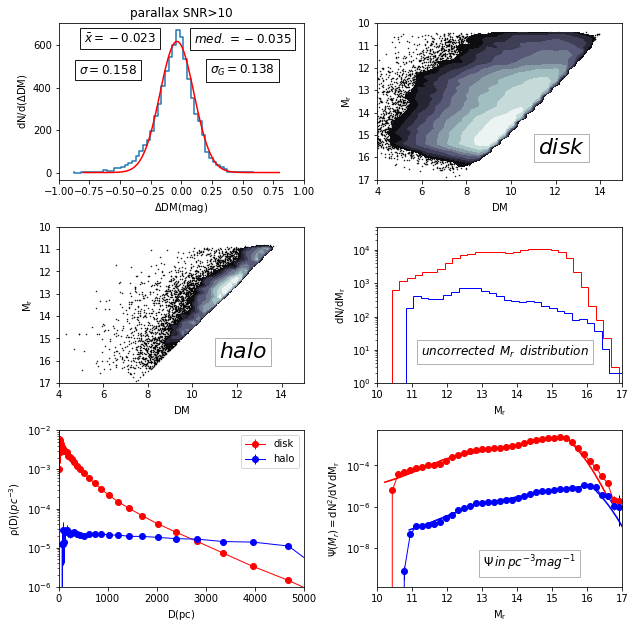

In [8]:
# run Cminus and make the plot (~12 min, or a few sec when CminusZI.npz already exists)
doAstr511HW2(truth, obs, diskLF, haloLF)

Mr fitting bias and rms: -0.0073812010321185895 0.16313984301793857
size: 173130 9627
nLSST = 7


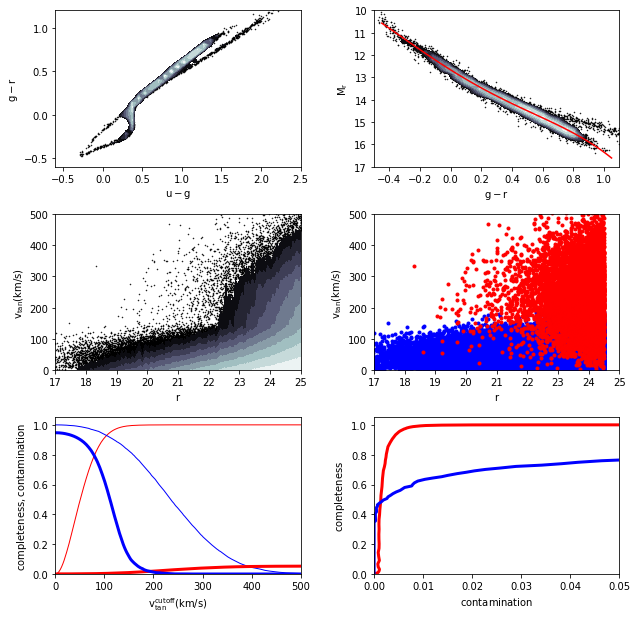

In [9]:
doAstr511HW2aux(truth, obs)

In [10]:
## with true Mr: 
# size of xCD 173108
# size of xCH 9637
# samples with x<11 and y<13.5, D and H: 49791 2065

# Mr fitting bias and rms: -0.0073811897894 0.163139843018
# observed sample size of xCD (disk) 155912
# observed sample size of xCH (halo) 8671

# - computing bootstrapped differential luminosity function 
# Disk sample with 155912 points
# Halo sample with 8671 points
# Size of volume-limited samples D and H: 45930  and  1935 (DM< 11.0 , Mr< 13.5 )
# Cdisk =  536053.340214 Chalo =  575453.789122
# rhoD0 0.00444677138354  scale height H (pc) = 299.561790007
# rhoH0 2.07651208749e-05